<h2>Exploratory Data Analysis</h2>

In this EDA we are exploring the Kickstarter dataset retrieved from Kaggle from the following url:
https://www.kaggle.com/datasets/ulrikthygepedersen/kickstarter-projects

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import np_utils, to_categorical

df = pd.read_csv("kickstarter_projects.csv")
df['Year'] = pd.DatetimeIndex(df['Launched']).year
df.shape

SEED = 420

In [2]:
df.head(10)

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State,Year
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,2009
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,2009
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful,2009
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful,2009
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed,2009
5,2089078683,New York Makes a Book!!,Journalism,Journalism,United States,2009-04-28 13:55:41,2009-05-16,3000,3329,110,Successful,2009
6,830477146,Web Site for Short Horror Film,Film & Video,Shorts,United States,2009-04-29 02:04:21,2009-05-29,200,41,3,Failed,2009
7,266044220,Help me write my second novel.,Publishing,Fiction,United States,2009-04-29 02:58:50,2009-05-29,500,563,18,Successful,2009
8,1502297238,Produce a Play (Canceled),Theater,Theater,United States,2009-04-29 04:37:37,2009-06-01,500,0,0,Canceled,2009
9,813230527,Sponsor Dereck Blackburn (Lostwars) Artist in ...,Music,Rock,United States,2009-04-29 05:26:32,2009-05-16,300,15,2,Failed,2009


<h4>Description of Attributes</h4>

<ol>
    <li><strong>ID</strong>: Internal ID of the Kickstarter project.</li>
    <li><strong>Name</strong>: Name of the Kickstarter project.</li>
    <li><strong>Category/Subcategory</strong>: The main and sub categories of the Kickstarter project.</li>
    <li><strong>Country</strong>: Country of origin of the Kickstarter project.</li>
    <li><strong>Launched</strong>: The launch date of the Kickstarter project.</li>
    <li><strong>Deadline</strong>: The deadline of the Kickstarter project.</li>
    <li><strong>Goal</strong>: The goal amount in USD of the Kickstarter project.</li>
    <li><strong>Pledged</strong>: The current pledged amount of the Kickstarter project.</li>
    <li><strong>Backers</strong>: The current backers of the Kickstarter project.</li>
    <li><strong>State</strong>: The current funding state of the Kickstarter project.</li>
</ol>

From the descriptions we can see that the "State" represents the class variable. We can see that "Goal", "Category", "Subcategory" are the input variables, additionally we can create a new attribute "Duration" which is the total duration in days of the Kickstarter project and use it as an input variable.

In [3]:
# Check the data types of the columns
print(df.dtypes)

ID              int64
Name           object
Category       object
Subcategory    object
Country        object
Launched       object
Deadline       object
Goal            int64
Pledged         int64
Backers         int64
State          object
Year            int64
dtype: object


Here we check if there are any null points in the dataset. We can see below that all rows contain data.

In [4]:
print(df.isnull().any())

ID             False
Name           False
Category       False
Subcategory    False
Country        False
Launched       False
Deadline       False
Goal           False
Pledged        False
Backers        False
State          False
Year           False
dtype: bool


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
 11  Year         374853 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 34.3+ MB


<h4>State</h4>

Here we analyse the class variable.

In [6]:
# Check the distribution of the target variable
print(df['State'].value_counts())

Failed        197611
Successful    133851
Canceled       38751
Live            2798
Suspended       1842
Name: State, dtype: int64


The pie chart below shows the distribution of States of projects. We can see that more than half of all projects in the dataset are failures. Suspended and Live projects are not relevant to this project, hence we will remove it from the data set later.

We can also see that there is a class imbalance, we can address this by oversampling or undersampling the dataset to achieve a balance.

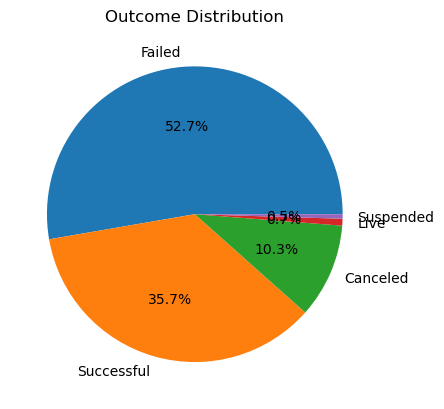

In [7]:
class_counts = df['State'].value_counts()

plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')

plt.title('Outcome Distribution')

plt.show()

<h4>Goal</h4>

Here we attempt to reveal insights as to whether successful projects tend to have comparatively higher or lower goals compared to failed or canceled projects.

We see from the boxplot graph below that Successful projects have consistently lower Goals when compared to Failed and Canceled projects.

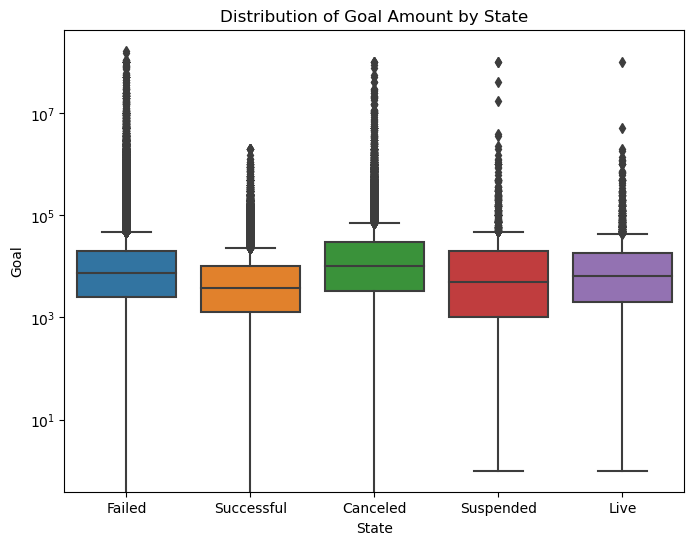

In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='State', y='Goal')
plt.xlabel('State')
plt.ylabel('Goal')
plt.yscale('log')
plt.title('Distribution of Goal Amount by State')
plt.show()

<h4>Category and Subcategory</h4>

In this section we explore the relationship of categories and subcategories with the project State.

Here we analyze the categorical variables. We first check which Categories most projects appear frequently in the dataset. From the graph below we can see that 'Film & Video', 'Music', 'Publishing' and 'Games' categories appear the most.

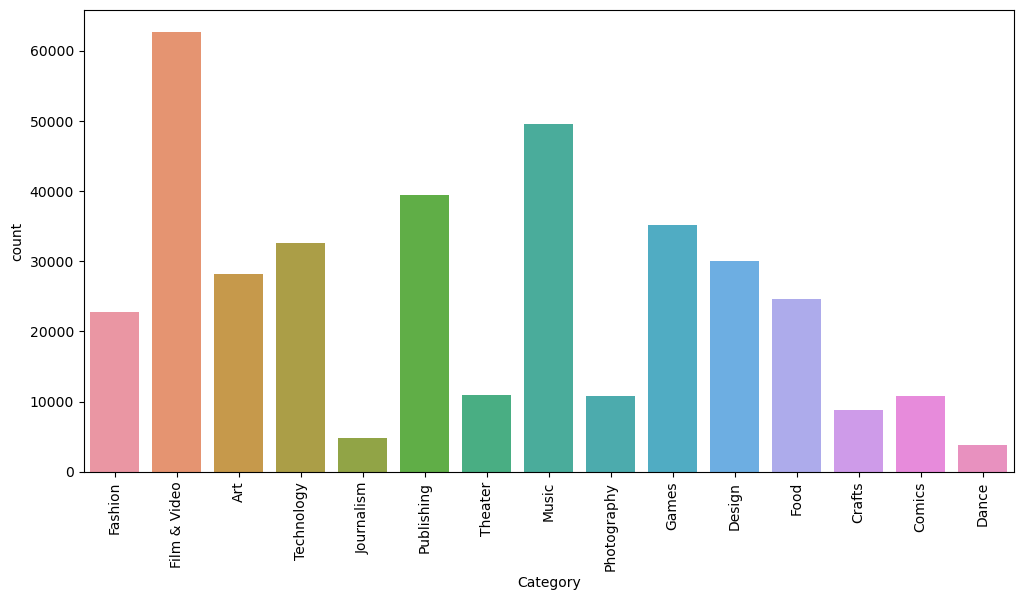

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category')  # Count plot of 'Category' attribute
plt.xticks(rotation=90)
plt.show()

Next we see for each category, how well do the projects do? How many projects failed or are successful or were cancelled?

From the graph below we can see that almost all categories fail more than they succeed. 'Theater', 'Music', 'Comics' and 'Dance', are the only project categories with more success than failures.

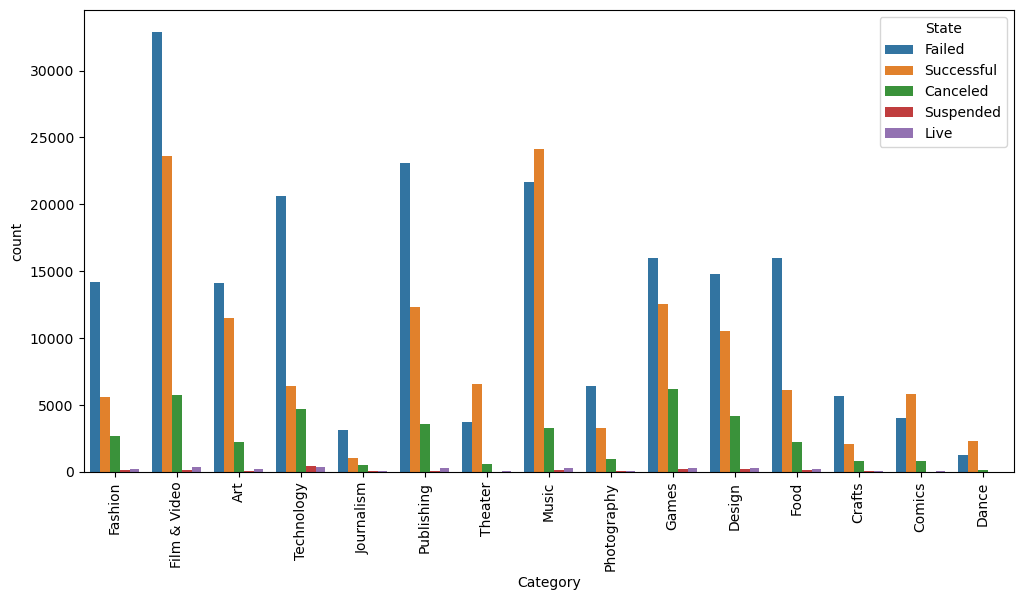

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category', hue='State')  # Count plot of 'Category' with hue as 'State'
plt.xticks(rotation=90)
plt.show()

Next we analyze how the Subcategories may affect outcomes. From the graph below we can see that there are a lot of project failures, for most of the Subcategories. 

However subcategories such as 'Shorts', 'Tabletop Games' and 'Comic Books' have a higher success rate. There seems to be a  correlation between Subcategories and project outcome.

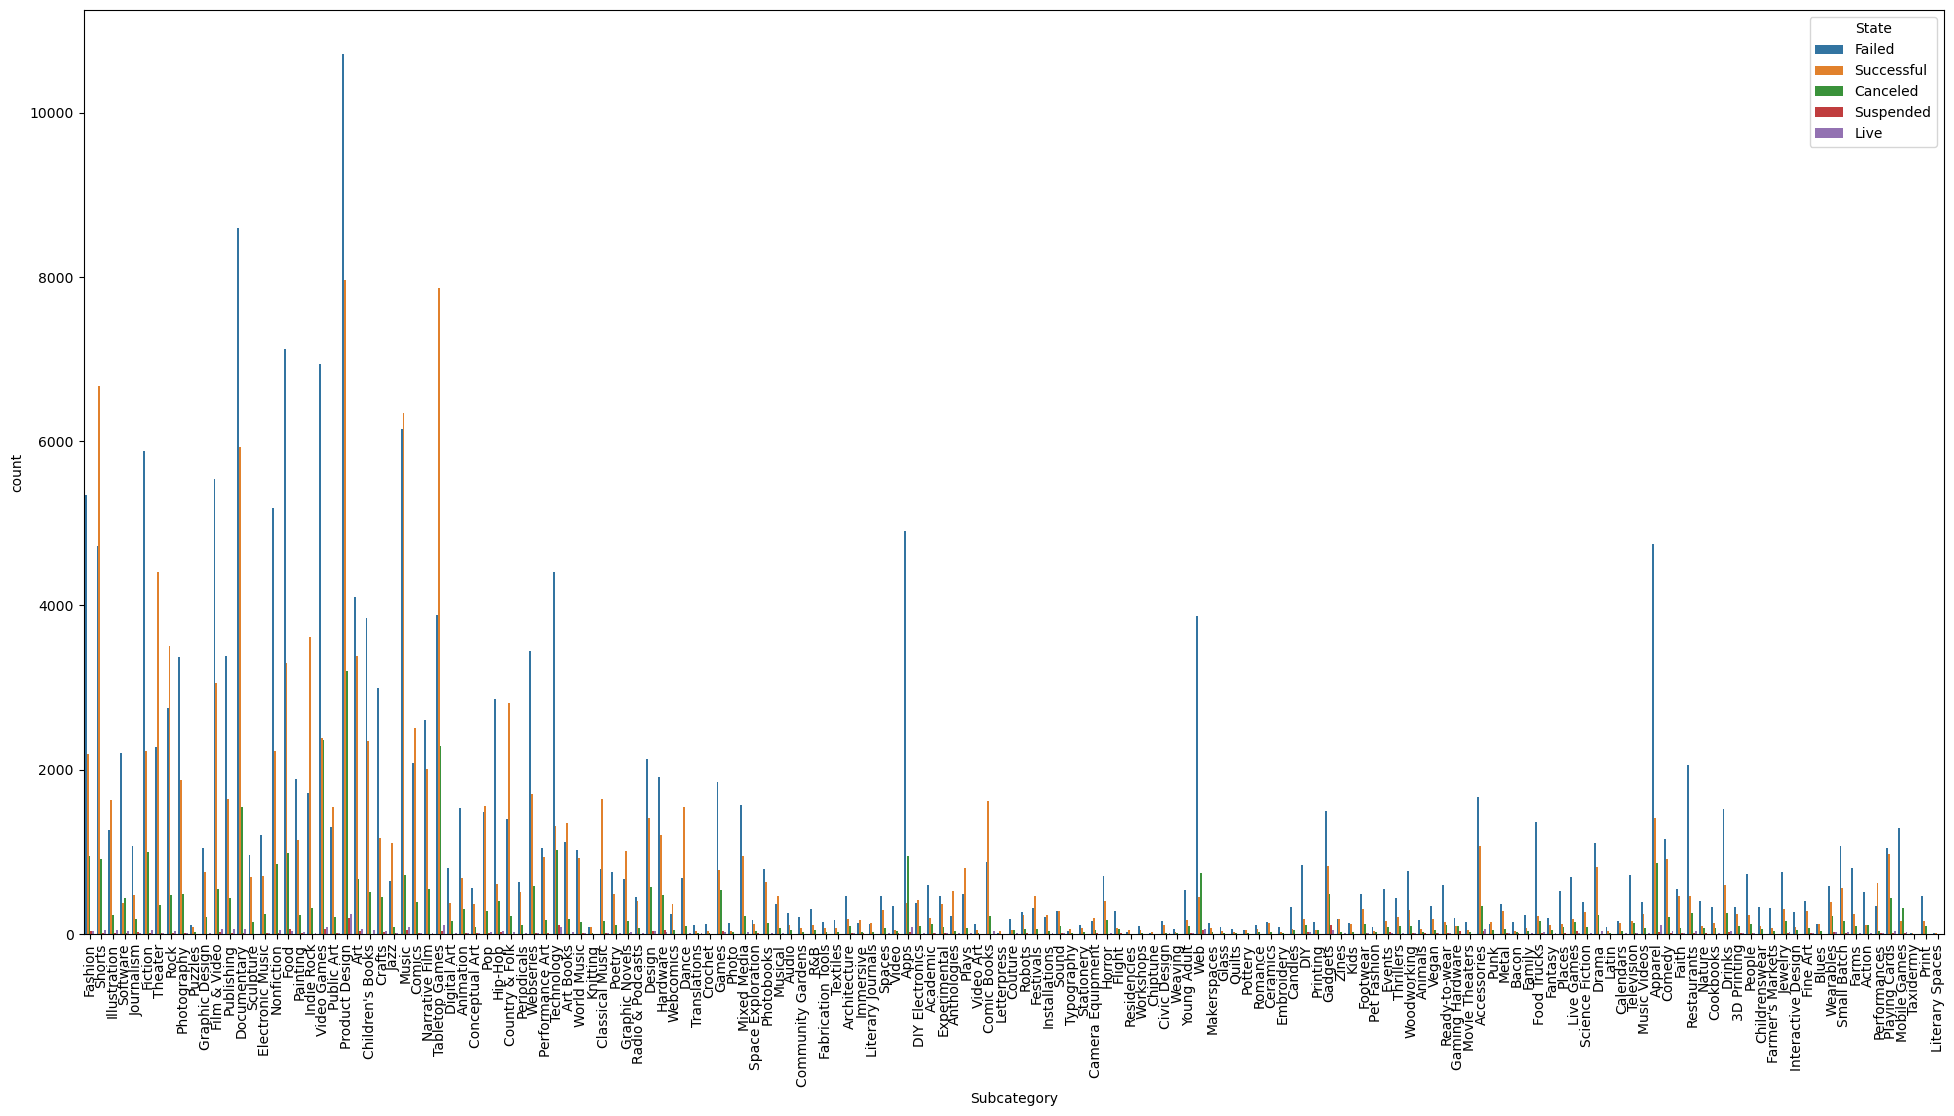

In [11]:
plt.figure(figsize=(24, 12))
sns.countplot(data=df, x='Subcategory', hue='State')
plt.xticks(rotation=90)
plt.show()

<h2>Data Cleaning</h2>

In this section we will prepare the dataset to develop the model.

Here we remove ID and Name data points as they are unique identifiers. We also remove Pledged and Backers to address cold start problem.

In [12]:
columns_to_drop = ['ID', 'Name', 'Pledged', 'Backers']
df = df.drop(columns_to_drop, axis=1)

We will also remove Live and Suspended projects, as we are only interested in Successful, Canceled and Failed projects.

In [13]:
df = df.drop(df[df['State'] == 'Suspended'].index)
df = df.drop(df[df['State'] == 'Live'].index)

<h3>Feature Engineering</h3>

Now we will add a new column Duration, which is the total duration of days for each Kickstarter project. This will be another input for the predictive model.

In [14]:
df['Duration'] = (pd.to_datetime(df['Deadline']) - pd.to_datetime(df['Launched'])).dt.days
df.head(10)

,Category,Subcategory,Country,Launched,Deadline,Goal,State,Year,Duration
0,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,Failed,2009,39
1,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,Failed,2009,87
2,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,Successful,2009,8
3,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,Successful,2009,79
4,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,Failed,2009,28
5,Journalism,Journalism,United States,2009-04-28 13:55:41,2009-05-16,3000,Successful,2009,17
6,Film & Video,Shorts,United States,2009-04-29 02:04:21,2009-05-29,200,Failed,2009,29
7,Publishing,Fiction,United States,2009-04-29 02:58:50,2009-05-29,500,Successful,2009,29
8,Theater,Theater,United States,2009-04-29 04:37:37,2009-06-01,500,Canceled,2009,32
9,Music,Rock,United States,2009-04-29 05:26:32,2009-05-16,300,Failed,2009,16


<h3>Preprocessing</h3>

In [18]:
NUMERICAL_VARIABLES = ["Duration", "Goal", "Year"]
CATEGORICAL_VARIABLES = ["Category", "Subcategory", "Country"]
TARGET_VARIABLE = "State"

# Split data into features and target
X = df[NUMERICAL_VARIABLES + CATEGORICAL_VARIABLES]
y = df[TARGET_VARIABLE]

# Convert categorical variables to one-hot encoding
X = pd.get_dummies(X, columns=CATEGORICAL_VARIABLES)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical variables
scaler = StandardScaler()
X_train[NUMERICAL_VARIABLES] = scaler.fit_transform(X_train[NUMERICAL_VARIABLES])
X_test[NUMERICAL_VARIABLES] = scaler.transform(X_test[NUMERICAL_VARIABLES])

In [19]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [20]:
# Oversample using SMOTE
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [21]:
# Split the resampled data into train and validation sets
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.1, random_state=42
)

In [22]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_val_resampled)

<h3>Baseline Performance</h3>

In [24]:
counts = df.groupby([TARGET_VARIABLE])[TARGET_VARIABLE].count()

print(counts)

baseline = counts.iloc[1] / counts.sum()

baseline

State
Canceled       38751
Failed        197611
Successful    133851
Name: State, dtype: int64


0.5337765016355449

In [26]:
balanced_accuracy_score(y_train, np.zeros(len(y_train)))

0.3333333333333333

<h3>Developing a model that outperforms the baseline</h3>

In [27]:
# Build and train a deep learning model
model = Sequential()
model.add(Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))  # Use unique classes
model.compile(loss='sparse_categorical_crossentropy', optimizer=('rmsprop'), metrics=['accuracy'])

In [28]:
# Train the model
model.fit(X_train_resampled, y_train_encoded, epochs=20, batch_size=32, verbose=0)

In [29]:
# Evaluate the model on resampled and original test sets
y_pred_encoded_resampled = model.predict(X_val_resampled)
# Get predicted class indices
y_pred_indices_resampled = y_pred_encoded_resampled.argmax(axis=1)
# Convert indices to class labels using label_encoder
y_pred_resampled = label_encoder.inverse_transform(y_pred_indices_resampled)

print("Classification Report for Model on Resampled Test Set:")
print(classification_report(y_val_resampled, y_pred_resampled))

y_pred_encoded_original = model.predict(X_test)
# Get predicted class indices for the original test set
y_pred_indices_original = y_pred_encoded_original.argmax(axis=1)

# Convert indices to class labels using label_encoder
y_pred_original = label_encoder.inverse_transform(y_pred_indices_original)

print("Classification Report for Model on Original Test Set:")
print(classification_report(y_test, y_pred_original))

1481/1481 [==============================] - 1s 558us/step
Classification Report for Model on Resampled Test Set:
              precision    recall  f1-score   support

           0       0.51      0.46      0.48     15707
           1       0.46      0.30      0.36     15757
           2       0.49      0.71      0.58     15925

    accuracy                           0.49     47389
   macro avg       0.48      0.49      0.47     47389
weighted avg       0.48      0.49      0.47     47389

2314/2314 [==============================] - 1s 551us/step
Classification Report for Model on Original Test Set:
              precision    recall  f1-score   support

           0       0.17      0.40      0.24      7688
           1       0.68      0.30      0.42     39649
           2       0.50      0.71      0.58     26706

    accuracy                           0.46     74043
   macro avg       0.45      0.47      0.41     74043
weighted avg       0.56      0.46      0.46     74043



<h3>Developing a model that Overfits</h3>

In [30]:
# Build and train a deep learning model that overfits
overfit_model = Sequential()
overfit_model.add(Dense(512, input_dim=X_train_resampled.shape[1], activation='relu'))
overfit_model.add(Dense(256, activation='relu'))
overfit_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))  # Use unique classes
overfit_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [31]:
# Train the model on the resampled dataset
overfit_model.fit(X_train_resampled, y_train_encoded, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

In [32]:
# Get predicted class indices for the resampled validation and original test sets
y_pred_encoded_val_resampled = overfit_model.predict(X_val_resampled)
y_pred_indices_val_resampled = y_pred_encoded_val_resampled.argmax(axis=1)
y_pred_encoded_original = overfit_model.predict(X_test)
y_pred_indices_original = y_pred_encoded_original.argmax(axis=1)

# Convert indices to class labels using label_encoder
y_pred_val_resampled = label_encoder.inverse_transform(y_pred_indices_val_resampled)
y_pred_original = label_encoder.inverse_transform(y_pred_indices_original)

# Evaluate the overfitting model on resampled validation and original test sets
print("Classification Report for Overfitting Model on Resampled Validation Set:")
print(classification_report(y_val_resampled, y_pred_val_resampled))

print("Classification Report for Overfitting Model on Original Test Set:")
print(classification_report(y_test, y_pred_original))

2314/2314 [==============================] - 1s 583us/step
Classification Report for Overfitting Model on Resampled Validation Set:
              precision    recall  f1-score   support

           0       0.46      0.56      0.50     15707
           1       0.44      0.30      0.36     15757
           2       0.53      0.58      0.55     15925

    accuracy                           0.48     47389
   macro avg       0.48      0.48      0.47     47389
weighted avg       0.48      0.48      0.47     47389

Classification Report for Overfitting Model on Original Test Set:
              precision    recall  f1-score   support

           0       0.15      0.52      0.23      7688
           1       0.66      0.30      0.42     39649
           2       0.54      0.58      0.56     26706

    accuracy                           0.43     74043
   macro avg       0.45      0.47      0.40     74043
weighted avg       0.56      0.43      0.45     74043



<h3>Regularizing the model and tuning hyperparameters</h3>

In [33]:
# Build a function to create the Keras model
def create_model(optimizer='rmsprop', hidden_layers=1, neurons=8, activation='relu', dropout=0.25):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_resampled.shape[1], activation=activation))
    
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout))
    
    model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [34]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [35]:
# Create a KerasClassifier
keras_model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters to tune
params = {
    'optimizer': ['rmsprop', 'adam'],
    'hidden_layers': [1, 2, 3, 4],
    'neurons': [8, 16, 32, 64],
    'activation': ['relu', 'sigmoid'],
    'dropout': [0.2, 0.3, 0.4]
}

C:\Users\Admin\AppData\Local\Temp\ipykernel_12816\4186933599.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=create_model, verbose=0)


In [36]:
# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=keras_model, param_grid=params, scoring='accuracy', cv=3)
grid_result = grid_search.fit(X_train_resampled, y_train_encoded)

4443/4443 [==============================] - 2s 527us/step


4443/4443 [==============================] - 3s 572us/step


4443/4443 [==============================] - 3s 640us/step


In [37]:
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'activation': 'relu', 'dropout': 0.2, 'hidden_layers': 2, 'neurons': 64, 'optimizer': 'adam'}


<h3>Evaluation</h3>

In the following cells we will see the results of the classifiers on the test set.

In [38]:
# Get the best model from the grid search
best_model = grid_result.best_estimator_

# Predict on the resampled validation and original test sets
y_pred_val_resampled_probs_best = best_model.predict(X_val_resampled)
y_pred_val_resampled_labels_best = label_encoder.inverse_transform(y_pred_val_resampled_probs_best)

y_pred_original_probs_best = best_model.predict(X_test)
y_pred_original_labels_best = label_encoder.inverse_transform(y_pred_original_probs_best)

# Evaluate the best model on resampled validation and original test sets
print("Classification Report for Best Model on Resampled Validation Set:")
print(classification_report(y_val_resampled, y_pred_val_resampled_labels_best))

print("Classification Report for Best Model on Original Test Set:")
print(classification_report(y_test, y_pred_original_labels_best))

2314/2314 [==============================] - 1s 551us/step
Classification Report for Best Model on Resampled Validation Set:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45     15707
           1       0.44      0.45      0.45     15757
           2       0.52      0.63      0.57     15925

    accuracy                           0.49     47389
   macro avg       0.49      0.49      0.49     47389
weighted avg       0.49      0.49      0.49     47389

Classification Report for Best Model on Original Test Set:
              precision    recall  f1-score   support

           0       0.17      0.34      0.23      7688
           1       0.67      0.46      0.54     39649
           2       0.53      0.62      0.57     26706

    accuracy                           0.51     74043
   macro avg       0.46      0.48      0.45     74043
weighted avg       0.57      0.51      0.52     74043



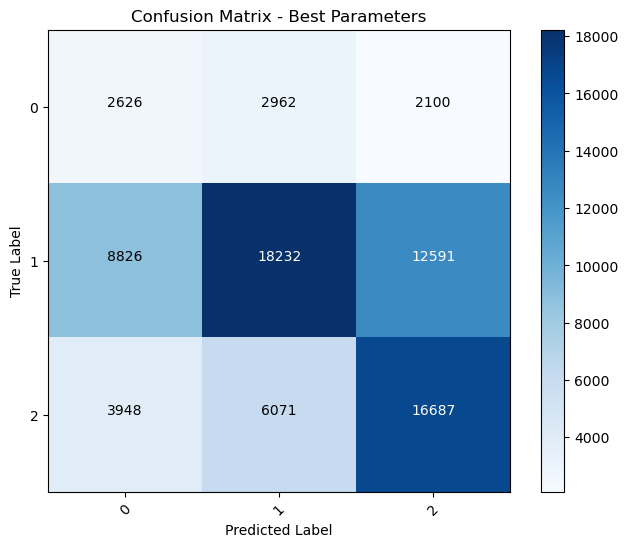

In [39]:
# Create a confusion matrix for the original test set
confusion = confusion_matrix(y_test, y_pred_original_labels_best)

# Plot the confusion matrix with numbers in cells
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Parameters')
plt.colorbar()

class_names = label_encoder.classes_
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the numbers in the cells
thresh = confusion.max() / 2.0
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.show()